In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point
from pyproj import Proj, Transformer

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-single network 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 9546.36it/s]


In [6]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}

In [7]:
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [8]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

city_sub_order_route_dict

{'Metro 50: Gein => Isolatorweg':     id                 name                      geometry     geo_x      geo_y
 0    5                 Gein  POINT (4.9891612 52.2964067)  4.989161  52.296407
 1   18           Reigersbos  POINT (4.9740002 52.2956365)     4.974  52.295637
 2   17          Holendrecht  POINT (4.9601264 52.2981319)  4.960126  52.298132
 3    6            Bullewijk   POINT (4.9521292 52.306869)  4.952129  52.306869
 4    4        Bijlmer ArenA   POINT (4.9476178 52.311806)  4.947618  52.311806
 5    3          Strandvliet  POINT (4.9413977 52.3186119)  4.941398  52.318612
 6   16         Duivendrecht  POINT (4.9365601 52.3236024)   4.93656  52.323602
 7    7      Van der Madeweg  POINT (4.9304544 52.3297847)  4.930454  52.329785
 8    9           Overamstel  POINT (4.9176063 52.3317688)  4.917606  52.331769
 9   19          Station RAI    POINT (4.889539 52.337689)  4.889539  52.337689
 10  10                 Zuid  POINT (4.8739633 52.3393223)  4.873963  52.339322
 11   8

In [9]:
df1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df1 = df1[0::4].reset_index(drop=True)
df1.columns = ['name']
df1.name[9] = 'Zuid' 
df1.name[13] = 'Lelylaan' 
df1.name[16] = 'De Vlugtlaan' 
df1

,name
0,Centraal Station
1,Nieuwmarkt
2,Waterlooplein
3,Weesperplein
4,Wibautstraat
5,Amstelstation
6,Spaklerweg
7,Overamstel
8,Station RAI
9,Zuid


In [10]:
df = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df1,df,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]
df_reordered

,id,name,geometry,geo_x,geo_y
0,4,Centraal Station,POINT (4.9008686 52.3773546),4.900869,52.377355
1,17,Nieuwmarkt,POINT (4.9009379 52.3714238),4.900938,52.371424
2,16,Waterlooplein,POINT (4.9036061 52.3666363),4.903606,52.366636
3,18,Weesperplein,POINT (4.9078472 52.3613094),4.907847,52.361309
4,3,Wibautstraat,POINT (4.9118953 52.3545601),4.911895,52.35456
5,5,Amstelstation,POINT (4.9174059 52.3466361),4.917406,52.346636
6,6,Spaklerweg,POINT (4.9208004 52.3402348),4.9208,52.340235
7,8,Overamstel,POINT (4.9176682 52.3316938),4.917668,52.331694
8,15,Station RAI,POINT (4.889539 52.337689),4.889539,52.337689
9,9,Zuid,POINT (4.8739633 52.3393223),4.873963,52.339322


In [11]:
key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'

# Replace the DataFrame with the new DataFrame
city_sub_order_route_dict[key_to_replace] = df_reordered

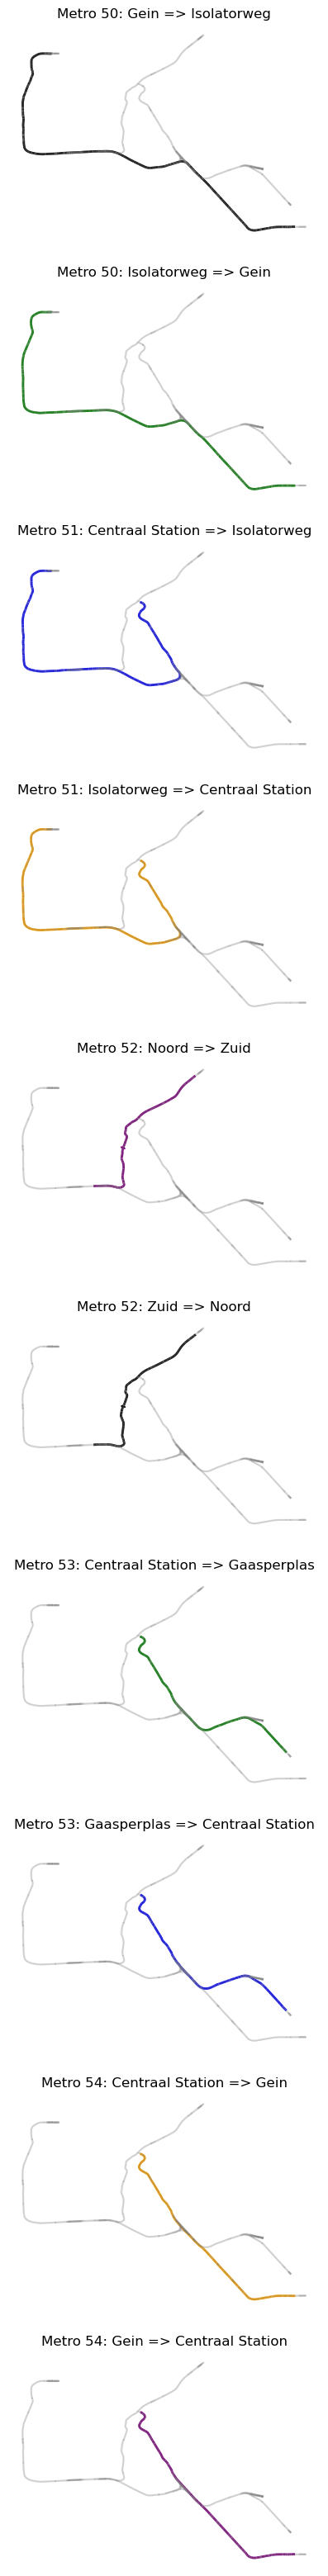

In [12]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, nodes)

# Create a graph representing the subway network using the extracted edges and nodes
G = create_ground_graph(edges, nodes)

# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges = city_sub_order_id_pairs.copy()
city_sub_edges = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges[line], city_sub_edges[line] = edges_with_count_weight(city_sub_shortest_path_pairs[line], edges)
    sub_edges = city_sub_edges[line]

# # Plot the subway routes with even indices
# plot_routes_even(city_sub_routes, edges, city_sub_shortest_path_edges)

# # Plot the subway routes with odd indices
# plot_routes_odd(city_sub_routes, edges, city_sub_shortest_path_edges)
    
# Plot all subway routes
plot_routes(city_sub_routes, edges, city_sub_shortest_path_edges)

In [18]:
df51_1 = city_sub_shortest_path_edges['Metro 50: Gein => Isolatorweg']
df51_2 = city_sub_shortest_path_edges['Metro 50: Isolatorweg => Gein']

df52_1 = city_sub_shortest_path_edges['Metro 52: Noord => Zuid'] 
df52_2 = city_sub_shortest_path_edges['Metro 52: Zuid => Noord']

df53_1 = city_sub_shortest_path_edges['Metro 53: Centraal Station => Gaasperplas']
df53_2 = city_sub_shortest_path_edges['Metro 53: Gaasperplas => Centraal Station']

df54_1 = city_sub_shortest_path_edges['Metro 54: Centraal Station => Gein']
df54_2 = city_sub_shortest_path_edges['Metro 54: Gein => Centraal Station']

In [20]:
gpd.GeoDataFrame(df51_1[['osm_id', 'geometry','id']]).to_file('df51_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df51_2[['osm_id', 'geometry','id']]).to_file('df51_2_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df52_1[['osm_id', 'geometry','id']]).to_file('df52_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df52_2[['osm_id', 'geometry','id']]).to_file('df52_2_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df53_1[['osm_id', 'geometry','id']]).to_file('df53_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df53_2[['osm_id', 'geometry','id']]).to_file('df53_2_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df54_1[['osm_id', 'geometry','id']]).to_file('df54_1_0229.GPKG',driver='GPKG')
gpd.GeoDataFrame(df54_2[['osm_id', 'geometry','id']]).to_file('df54_2_0229.GPKG',driver='GPKG')